# Retrieving Region of Interest by separating Lung Paranchyma in a CT scan
### Author- Anupreet Singh(UMBC Campus ID-UK43298)

In [1]:
## Setting up dependecies in the environment 
%pip install opencv-python matplotlib 
import cv2
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


### TECH NOTE(OPEN CV)
1. When you read an image using open cv, it gets stored as a numpy array(2-D matrix in case of grayscale image)
2. The shape of image is (height, widht)
3. The X-axis(horizontal) and Y-axis(vertical) begin at the top left corner.<br> 
X-axis extends rightward and Y-axis extends downwards.<br>
Therefore, image[20, 30] refers to the 20th row (Y-axis) and the 30th column (X-axis) of the image, starting from the top-left corner.



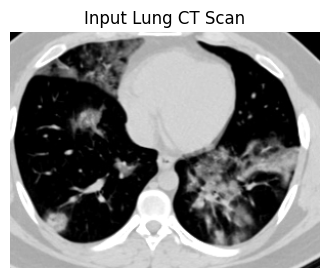

In [8]:
## Step 1 of 7: Loading an Image
# Path to the image file(Replace with the image path on your system)
image_path = "/Users/manpreetsingh/Downloads/UMBC/SEM-2/Cryptography-652/Project/652_Project_Code/watermarking-attack/datasets/ctscan/raw/COVID/Covid (30).png"  

# Read the image in grayscale
input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image was successfully loaded
if input_image is None:
    raise ValueError("Image not found or path is incorrect.")

# Displaying the image
plt.figure(figsize=(4, 4)) # Creates a new figure/ sets a canvas to draw on.
plt.imshow(input_image, cmap='gray') # Loads the image stored as numpy array in "input_image", using the grayscale colormap
plt.title("Input Lung CT Scan")#Adds Title above the image
plt.axis('off')# Hides the X and Y axis
plt.show()# Renders the figure for displaying in the notebook

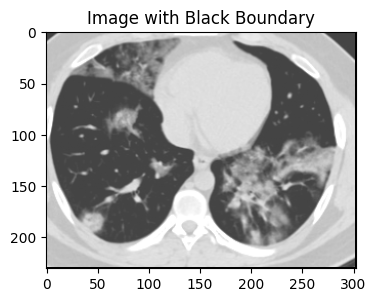

In [9]:
## Step 2 of 7: Drawing a black Boundary on the input image, in this case the black boundary is just at the edge of the of image
# Make a copy of the input image so we don't overwrite the original
image_boundary = input_image.copy()

# Drawing a black border (1 pixel wide) on all sides of the image by putting the intensity to 0(Black)
image_boundary[0, :] = 0             # Top row
image_boundary[-1, :] = 0            # Bottom row
image_boundary[:, 0] = 0             # Left most column
image_boundary[:, -1] = 0            # Right most column

# Display the image with the black boundary
plt.figure(figsize=(4, 4))
plt.imshow(image_boundary, cmap='gray')
plt.title("Image with Black Boundary")
# plt.axis('off')
plt.show()


Otsu's Threshold (Tfinal): 144.0


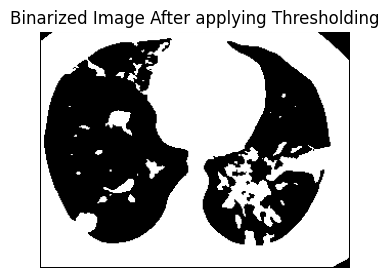

In [10]:
## Step 3 of 7: Use OpenCV's built-in Otsu's method to compute threshold & Step 4 of 7: Turn all pixels greater than T_final white to get binarized_image
# cv2.threshold returns both threshold and the binarized image
# All pixels > Tfinal → 255 (white), else → 0 (black)
T_final, binarized_image  = cv2.threshold(
    image_boundary,      # Input image (must be grayscale)
    0,             # Initial threshold value (ignored when using Otsu)
    255,           # Max value to use in binary thresholding
    cv2.THRESH_BINARY + cv2.THRESH_OTSU #Tells opencv to perform binary thresholding with otsu's method
)

print(f"Otsu's Threshold (Tfinal): {T_final}")

#Displaying the binarized result
plt.figure(figsize=(4, 4))
plt.imshow(binarized_image, cmap='gray')
plt.title("Binarized Image After applying Thresholding")
plt.axis('off')
plt.show()


In [11]:
## Step 5 of 7 Find the seed pixels
# The lungs are dark, and were kept black (0) after binarization.
#In each of the 4 Quadrants of the image, We're looking for the first black pixel — that’s your seed for that quadrant.

height, width = binarized_image.shape #Storing the height and width 
margin = 1 # Setting margin of 1 since edges are the black boundary itself(1st pixel), so we start from pixel on the inside edge of the black boundary

# Lines dividing the four quadrants
mid_row = height // 2
mid_col = width // 2

seeds = {} # making a dictionary to store the seeds for each quadrant

# Quadrant 1: Upper-left (start from left edge of center row of Quadrant 1, move right)
row_q1 = height // 4 
for x in range(margin, mid_col):
    if binarized_image[row_q1, x] == 0:# The first black pixel we encounter
        seeds['upper_left'] = (row_q1, x)# storing the seed
        print("Upper-left seed:", seeds['upper_left'])# Printing the seed
        break

# Quadrant 2: Lower-left (start from left edge of center row of Quadrant 2, move right)
row_q2 = 3 * height // 4
for x in range(margin, mid_col):
    if binarized_image[row_q2, x] == 0:
        seeds['lower_left'] = (row_q2, x)# storing the seed
        print("Lower-left seed:", seeds['lower_left'])# Printing the seed
        break

# Quadrant 3: Upper-right (start from right edge of center row of Quadrant 3, move left)
row_q3 = height // 4
for x in range(width - 1 - margin, mid_col, -1):
    if binarized_image[row_q3, x] == 0:# The first black pixel we encounter
        seeds['upper_right'] = (row_q3, x)# storing the seed
        print("Upper-right seed:", seeds['upper_right'])# Printing the seed
        break

# Quadrant 4: Lower-right (start from right edge of center row of Quadrant 4, move left)
row_q4 = 3 * height // 4
for x in range(width - 1 - margin, mid_col, -1):
    if binarized_image[row_q4, x] == 0:# The first black pixel we encounter
        seeds['lower_right'] = (row_q4, x)# storing the seed
        print("Lower-right seed:", seeds['lower_right'])# Printing the seed
        break




Upper-left seed: (57, 15)
Lower-left seed: (173, 25)
Upper-right seed: (57, 270)
Lower-right seed: (173, 262)


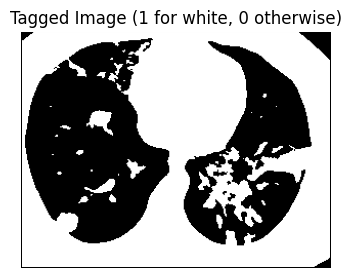

In [12]:
## Step 6: Creating a tagged image
"""
Syntax: np.where(condition, value_if_true, value_if_false)
np.where automatically checks the given condition for each element of the numpy array, and return a new array with updated values according to the conditions
Then .astype converts values of the return numpy array from integers to 8-bit unsigned integers(which is the standard usage for grayscale images)
"""
tagged_image = np.where(binarized_image == 255, 1, 0).astype(np.uint8)

plt.figure(figsize=(4, 4))
plt.imshow(tagged_image, cmap='gray')
plt.title("Tagged Image (1 for white, 0 otherwise)")
plt.axis('off')
plt.show()

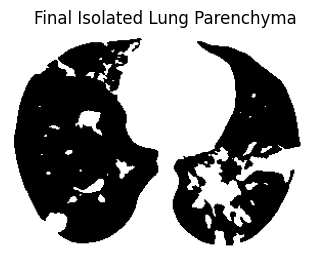

In [13]:
## Step 7 of 7: Growing region from Seeds
# Basically starts at a seed and expands to make the successive neighbours black, which were black in the tagged_image

# Make a white copy of the image to draw the lungs on basically
result_image = np.ones_like(binarized_image, dtype=np.uint8) * 255

# Mask to keep track of visited pixels
visited = np.zeros_like(tagged_image, dtype=bool)

# 4-connected neighbor directions(above, below, left, right)
neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

from collections import deque # importing deque for BFS basically 

# Loop through all 4 quadrant seeds
for seed_name in seeds:  # seeds is a dict with 4 quadrant seeds
    seed = seeds[seed_name]#seeds stores the location of the seeds for that quadrant
    if not visited[seed]:  # In case overlapping regions exist, we check if the current seeds has been visited in some other quadrants region expansion
        queue = deque([seed])# initialize the double ended queue with the seed
        visited[seed] = True # Mark the seed as True in the visited mask

        while queue:# Goes until the queue is empty
            y, x = queue.popleft()# retrieves the element from the begining of the queue
            result_image[y, x] = 0# Makes the element black

            for dy, dx in neighbors:#Iterates over 4 neighbours of the currently popped element
                ny, nx = y + dy, x + dx# Location of current neighbour 
                if (0 <= ny < result_image.shape[0]) and (0 <= nx < result_image.shape[1]): #Just a bound check to make sure the current location is inside the picture
                    if not visited[ny, nx] and tagged_image[ny, nx] == 0:# Checks that this neighbour/pixel hasn't been visited and it was black in the tagged/binarized image
                        queue.append((ny, nx))# Adds neighbour to the queue for its successive neighbour checks and making it black in the result_image
                        visited[ny, nx] = True# sets the neighbour as True in the visited mask

# Display the result
plt.figure(figsize=(4, 4))
plt.imshow(result_image, cmap='gray')
plt.title("Final Isolated Lung Parenchyma")
plt.axis('off')
plt.show()


